In [ ]:
import numpy as np
import re
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from IPython.display import HTML as html_print
from IPython.display import display





# Read and preprocess text
raw_text = """
sonu
"""
raw_text = re.sub(r'\s+', ' ', raw_text)

# Character mapping
chars = sorted(list(set(raw_text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

n_chars = len(raw_text)
n_vocab = len(chars)
seq_length = 100
dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)
X = np.reshape(dataX, (n_patterns, seq_length, 1)) / float(n_vocab)
y = to_categorical(dataY)



from keras.layers import Input

# Functional API to allow layer introspection
inputs = Input(shape=(seq_length, 1))
x = LSTM(512, return_sequences=True)(inputs)
x = Dropout(0.5)(x)
x2 = LSTM(512)(x)
x = Dropout(0.5)(x2)
outputs = Dense(y.shape[1], activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Save and Train
filepath = "weights-best.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
model.fit(X, y, epochs=5, batch_size=2048, callbacks=[checkpoint])

# Load Trained Model
model = load_model("weights-best.keras")

# Define intermediate model correctly (2nd LSTM output)
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[4].output)







# Visualization tools
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_clr(value):
    colors = ['#85c2e1','#89c4e2','#95cae5','#99cce6','#a1d0e8','#b2d9ec','#baddee','#c2e1f0','#eff7fb','#f9e8e8',
              '#f9e8e8','#f9d4d4','#f9bdbd','#f8a8a8','#f68f8f','#f47676','#f45f5f','#f34343','#f33b3b', '#f42e2e']
    idx = min(int(value * 20), 19)
    return colors[idx]

!apt-get update -qq
!apt-get install -y fonts-noto

def cstr(s, color='black'):
    if s == ' ':
        s = '&nbsp;'
    return f"""<span style="
        font-family: 'Noto Sans', 'Noto Sans Devanagari', sans-serif;
        color: black;
        background-color: {color};
        padding: 1px 3px;
        margin: 1px;
        display: inline-block;
    ">{s}</span>"""


def print_color(t):
    display(html_print(''.join([cstr(ti, color=ci) for ti, ci in t])))
    #display(HTML(''.join([cstr(c, color) for c, color in zip(chars, colors)])))

def visualize(output_values, result_list, cell_no):
    print(f"\nVisualizing Cell Number: {cell_no}\n")
    colored_seq = []
    for i in range(len(output_values)):
        text = (result_list[i], get_clr(output_values[i][cell_no]))
        colored_seq.append(text)
    print_color(colored_seq)

# Generate text and collect activations
def get_predictions(dataX):
    start = np.random.randint(0, len(dataX) - 1)
    pattern = dataX[start]
    result_list = []
    output_values = []

    print("Seed:")
    print("\"" + ''.join([int_to_char[value] for value in pattern]) + "\"")
    print("\nGenerated:")

    for i in range(100):
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        prediction = model.predict(x, verbose=0)
        output = intermediate_layer_model.predict(x)[0]  # Get output from second LSTM
        output = sigmoid(output)
        output_values.append(output)

        index = np.argmax(prediction)
        result = int_to_char[index]
        result_list.append(result)

        pattern.append(index)
        pattern = pattern[1:]

    return output_values, result_list

# Run inference and visualize selected cells
output_values, result_list = get_predictions(dataX)
for cell_no in [189, 435, 463]:
    visualize(output_values, result_list, cell_no)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


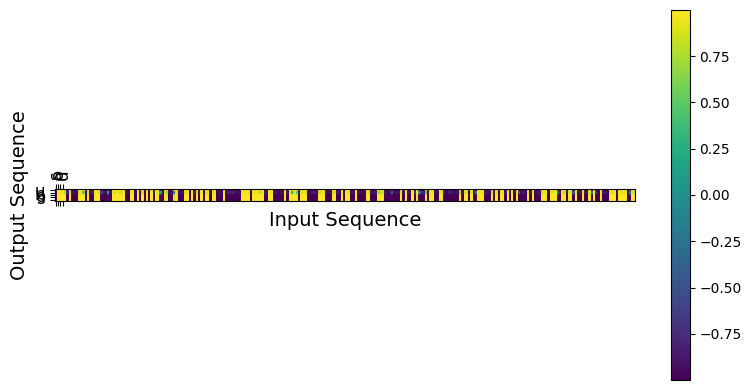

In [5]:
# ======================================
# 1. Setup and Data Preparation
# ======================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Dummy dataset: character-level English to reversed-English translation (can replace with Hindi transliteration)
input_texts = ['hello', 'world', 'sonu', 'test', 'chat']
target_texts = ['\t' + text[::-1] + '\n' for text in input_texts]  # reversed + start(\t)/end(\n) tokens

input_chars = sorted(list(set(''.join(input_texts))))
target_chars = sorted(list(set(''.join(target_texts))))

input_token_index = {char: i for i, char in enumerate(input_chars)}
target_token_index = {char: i for i, char in enumerate(target_chars)}
reverse_target_char_index = {i: char for char, i in target_token_index.items()}

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, len(input_chars)))
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_chars)))
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_chars)))

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0


# ======================================
# 2. Build Seq2Seq Model with Attention
# ======================================
encoder_inputs = Input(shape=(None, len(input_chars)))
encoder_lstm = LSTM(256, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, len(target_chars)))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention mechanism
attention = Attention()
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate attention output with decoder output
decoder_combined_context = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention_output])
decoder_dense = Dense(len(target_chars), activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=2, epochs=300, verbose=0)



# ======================================
# 3. Define Inference Models
# ======================================
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_hidden_state_input = Input(shape=(None, 256))

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    decoder_inputs, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

attention_output2 = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_combined_context2 = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs2, attention_output2])
decoder_outputs2 = decoder_dense(decoder_combined_context2)

decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2, attention_output2]
)


# ======================================
# 4. Inference + Attention Weights Visualization (Distill-style)
# ======================================
def decode_sequence(input_seq):
    encoder_outs, state_h, state_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1, len(target_chars)))
    target_seq[0, 0, target_token_index['\t']] = 1.0

    decoded_sentence = ''
    attentions = []

    for _ in range(max_decoder_seq_length):
        output_tokens, h, c, attention_weights = decoder_model.predict(
            [target_seq, encoder_outs, state_h, state_c]
        )

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        attentions.append(attention_weights[0, -1, :])
        
        if sampled_char == '\n':
            break

        target_seq = np.zeros((1, 1, len(target_chars)))
        target_seq[0, 0, sampled_token_index] = 1.0

        state_h, state_c = h, c

    return decoded_sentence, np.array(attentions)

# Pick an input to visualize
test_idx = 2
test_input = encoder_input_data[test_idx:test_idx+1]
decoded, attention_matrix = decode_sequence(test_input)

# Visualize like Distill: decoder steps (y-axis) attending to encoder steps (x-axis)
# def plot_attention(attention, input_text, predicted_text):
#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.matshow(attention, cmap='viridis')
    
#     ax.set_xticks(range(len(input_text)))
#     ax.set_xticklabels(list(input_text), fontdict={'fontsize': 14})
    
#     ax.set_yticks(range(len(predicted_text)))
#     ax.set_yticklabels(list(predicted_text), fontdict={'fontsize': 14})
    
#     ax.set_xlabel("Input Sequence", fontsize=14)
#     ax.set_ylabel("Output Sequence", fontsize=14)
#     plt.show()

def plot_attention(attention, input_text, predicted_text):
    fig, ax = plt.subplots(figsize=(max(8, len(input_text) * 0.4), max(4, len(predicted_text) * 0.4)))
    cax = ax.matshow(attention, cmap='viridis')

    # Proper ticks
    ax.set_xticks(range(len(input_text)))
    ax.set_yticks(range(len(predicted_text)))

    ax.set_xticklabels(list(input_text), fontdict={'fontsize': 12}, rotation=90)
    ax.set_yticklabels(list(predicted_text), fontdict={'fontsize': 12})

    ax.set_xlabel("Input Sequence", fontsize=14)
    ax.set_ylabel("Output Sequence", fontsize=14)

    # Add color bar
    fig.colorbar(cax)
    plt.tight_layout()
    plt.show()


decoded, attention_matrix = decode_sequence(test_input)
plot_attention(attention_matrix, input_texts[test_idx], decoded)


# Visualize
# plot_attention(attention_matrix, input_texts[test_idx], decoded)
